### Load data

In [1]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
%matplotlib inline

In [42]:
def get_one_clip(lst,index ,skip ,length  ):
    return lst[index:index+length*skip:skip]
def get_clips(img_lst,skip  ,length):
    clips =[get_one_clip(img_lst,i,skip,length) for i in range(len(img_lst)) if len(get_one_clip(img_lst,i,skip,length)) == length ]
    
    return clips
def get_pair(img_lst,pre ,skip  ,length):
    A = get_clips(img_lst[:][:-pre],skip  ,length)
    B = get_clips(img_lst[pre:],skip  ,length)
    return A,B
read_ = lambda x : cv2.resize(cv2.imread(x)[:, int(1242/2-375/2):int(1242/2+375/2),::-1],(256,256))
def gen_np(c):
#     print(c)
    img1 = [ read_(i)  for i in c[0]]
    img2 = [ read_(i)  for i in c[1]]


    v = np.asarray([img1,img2])
    v = np.transpose(v , (0,4,1,2,3))
#     v.transpose(0,4,1,2,3)
    return v
def dump(img_lst,dirpath='data' ,start =0 ,skip = 2 ,length =7 ,pre =2):

    a,b = get_pair(img_lst,pre ,skip  ,length)
    task = [ (i,j) for i ,j in zip(a,b)]
    for i ,j in enumerate(task):
        v = gen_np(j)
        np.save('{}{}.npy'.format(dirpath,i+start),v)
#         return 
      

In [40]:
def f(data_path):
    start = 0
    img_lst = glob.glob(data_path+"**.png")
    img_lst.sort()
    dump(img_lst,'video/{}{}'.format(*data_path.split('/')[-3:-1]),start,2 ,7 ,2)

In [30]:
f_lst = glob.glob('/data/dataset/depthdata/vkitti_1.3.1_rgb/**/**/')

In [43]:
with Pool(12) as p:
    p.map(f,f_lst)

In [47]:
fi =  'video/000115-deg-left0.npy'
a= np.load(fi)

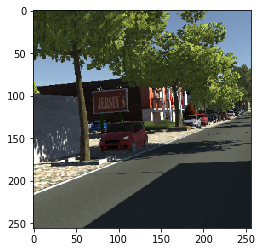

In [50]:
plt.imshow(np.transpose(a[0],(1,2,3,0))[2])

---

## 3D-UNet

In [14]:
import tensorflow as tf

In [15]:
from tf.keras import backend as K
from tf.keras.engine import Input, Model
from tf.keras.layers import Conv3D, MaxPooling3D, UpSampling3D, Activation
from tf.keras.optimizers import Adam
from tf.keras.layers.normalization import BatchNormalization
from keras_contrib.layers import Deconvolution3D

try:
    from tf.keras.engine import merge
except ImportError:
    from tf.tensorflow.keras.layers.merge import concatenate

ModuleNotFoundError: No module named 'tf'

In [18]:
tensorflow.keras.backend

NameError: name 'tensorflow' is not defined

In [17]:
dir(tf.keras)

AttributeError: module 'tensorflow' has no attribute 'keras'

In [137]:
dir(tf.keras)

AttributeError: module 'tensorflow' has no attribute 'keras'

In [114]:
def unet_3d(input_shape, downsize_filters_factor=1, initial_learning_rate=0.00001):
        
    inputs = Input(input_shape)
    conv1 = Conv3D(int(64/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(axis=1)(conv1)

    conv2 = Conv3D(int(128/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization(axis=1)(conv2)

    conv3 = Conv3D(int(256/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(conv2)
    conv3 = BatchNormalization(axis=1)(conv3)
    
    conv4 = Conv3D(int(512/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization(axis=1)(conv4)
    
    model = Model(inputs=inputs, outputs=conv4)
    
    print(model.summary())
    
    #up5 = get_upconv(deconvolution=deconvolution, depth=2,
                     #nb_filters=int(512/downsize_filters_factor), image_shape=input_shape[-3:])(conv4)
    ### To-do: continue
    
    

In [115]:
unet_3d((3, 64, 64, 16))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3, 64, 64, 16)     0         
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 3, 64, 64, 64)     27712     
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 64, 64, 64)     12        
_________________________________________________________________
conv3d_63 (Conv3D)           (None, 3, 64, 64, 128)    221312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 64, 64, 128)    12        
_________________________________________________________________
conv3d_64 (Conv3D)           (None, 3, 64, 64, 256)    884992    
_________________________________________________________________
batch_normalization_3 (Batch (None, 3, 64, 64, 256)    12        
__________

In [129]:
def unet_model_3d(input_shape, downsize_filters_factor=1, pool_size=(2, 2, 2), n_labels=1,
                  initial_learning_rate=0.00001, deconvolution=False):
    """
    Builds the 3D UNet Keras model.
    :param input_shape: Shape of the input data (n_chanels, x_size, y_size, z_size). 
    :param downsize_filters_factor: Factor to which to reduce the number of filters. Making this value larger will
    reduce the amount of memory the model will need during training.
    :param pool_size: Pool size for the max pooling operations.
    :param n_labels: Number of binary labels that the model is learning.
    :param initial_learning_rate: Initial learning rate for the model. This will be decayed during training.
    :param deconvolution: If set to True, will use transpose convolution(deconvolution) instead of upsamping. This
    increases the amount memory required during training.
    :return: Untrained 3D UNet Model
    """
    
    inputs = Input(input_shape)
    conv1 = Conv3D(int(32/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(int(64/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=pool_size)(conv1)

    conv2 = Conv3D(int(64/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(int(128/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=pool_size)(conv2)

    conv3 = Conv3D(int(128/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(int(256/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=pool_size)(conv3)

    conv4 = Conv3D(int(256/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(int(512/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(conv4)

    up5 = get_upconv(pool_size=pool_size, deconvolution=deconvolution, depth=2,
                     nb_filters=int(512/downsize_filters_factor), image_shape=input_shape[-3:])(conv4)
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv3D(int(256/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv3D(int(256/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = get_upconv(pool_size=pool_size, deconvolution=deconvolution, depth=1,
                     nb_filters=int(256/downsize_filters_factor), image_shape=input_shape[-3:])(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv3D(int(128/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(int(128/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = get_upconv(pool_size=pool_size, deconvolution=deconvolution, depth=0,
                     nb_filters=int(128/downsize_filters_factor), image_shape=input_shape[-3:])(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv3D(int(64/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(int(64/downsize_filters_factor), (3, 3, 3), activation='relu', padding='same')(conv7)

    #conv8 = Conv3D(n_labels, (1, 1, 1))(conv7)
    #act = Activation('sigmoid')(conv8)
    model = Model(inputs=inputs, outputs=conv7)    
    
    model.compile(optimizer=Adam(lr=initial_learning_rate), loss=dice_coef_loss, metrics=[dice_coef])
    
    print(model.summary())
    
    return model


def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def compute_level_output_shape(filters, depth, pool_size, image_shape):
    """
    Each level has a particular output shape based on the number of filters used in that level and the depth or number 
    of max pooling operations that have been done on the data at that point.
    :param image_shape: shape of the 3d image.
    :param pool_size: the pool_size parameter used in the max pooling operation.
    :param filters: Number of filters used by the last node in a given level.
    :param depth: The number of levels down in the U-shaped model a given node is.
    :return: 5D vector of the shape of the output node 
    """
    if depth != 0:
        output_image_shape = np.divide(image_shape, np.multiply(pool_size, depth)).tolist()
    else:
        output_image_shape = image_shape
    return tuple([None, filters] + [int(x) for x in output_image_shape])


def get_upconv(depth, nb_filters, pool_size, image_shape, kernel_size=(2, 2, 2), strides=(2, 2, 2),
               deconvolution=False):
    if deconvolution:
        try:
            from keras_contrib.layers import Deconvolution3D
        except ImportError:
            raise ImportError("Install keras_contrib in order to use deconvolution. Otherwise set deconvolution=False.")

        return Deconvolution3D(filters=nb_filters, kernel_size=kernel_size,
                               output_shape=compute_level_output_shape(filters=nb_filters, depth=depth,
                                                                       pool_size=pool_size, image_shape=image_shape),
                               strides=strides, input_shape=compute_level_output_shape(filters=nb_filters,
                                                                                       depth=depth+1,
                                                                                       pool_size=pool_size,
                                                                                       image_shape=image_shape))
    else:
        return UpSampling3D(size=pool_size)


In [130]:
X.shape

(3, 128, 128, 10)

In [132]:
model = unet_model_3d((64, 64, 16, 3), deconvolution=True)

ImportError: Install keras_contrib in order to use deconvolution. Otherwise set deconvolution=False.

In [93]:
import os


config = dict()
config["pool_size"] = (2, 2, 2)
config["image_shape"] = (144, 144, 144)  # This determines what shape the images will be cropped/resampled to.
config["n_labels"] = 1  # not including background
config["batch_size"] = 1
config["n_epochs"] = 50
config["data_dir"] = os.path.abspath("./brats/data")
config["decay_learning_rate_every_x_epochs"] = 10
config["initial_learning_rate"] = 0.00001
config["learning_rate_drop"] = 0.5
config["validation_split"] = 0.8
config["hdf5_file"] = os.path.abspath("./brats/data.hdf5")
config["model_file"] = os.path.abspath("./brats/3d_unet_model.h5")
config["training_file"] = os.path.abspath("./brats/training_ids.pkl")
config["validation_file"] = os.path.abspath("./brats/validation_ids.pkl")
config["smooth"] = 1.
config["modalities"] = ["T1", "T1c", "Flair", "T2"]
config["training_modalities"] = ["T1", "T1c", "Flair"]  # set this to the modalities that you want the model to use
config["nb_channels"] = len(config["training_modalities"])
config["input_shape"] = tuple([config["nb_channels"]] + list(config["image_shape"]))
config["truth_channel"] = config["nb_channels"]
config["background_channel"] = config["nb_channels"] + 1
config["deconvolution"] = False  # use deconvolution instead of up-sampling. Requires keras-contrib.
# divide the number of filters used by by a given factor. This will reduce memory consumption.
config["downsize_nb_filters_factor"] = 1

In [94]:
tuple([config["nb_channels"]] + list(config["image_shape"]))

(3, 144, 144, 144)

In [107]:
a

array([[[[ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.]],

        [[ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.]],

        [[ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.]],

        [[ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.]]],


       [[[ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.],
      